**Contents**

1. Introduction and motivation
2. Read preprocess raw data
3. Descriptive analysis: data visualization
4. Feature extraction and engineering
5. Descriptive analysis: unsupervised learning
6. Predictive analysis: classification model
7. Predictive analysis: regression model
8. Prescriptive analysis

## Introduction and motivation

We are interested in assessing the effectiness of governmental Non-Pharmaceutical Interventions (henceforth referred to as **NPIs**) such as the closing of schools, travel bans, and restriction of movement in public spaces, in response to the recent Covid-19 pandemic. Ultimately, our aim is to be able to make informed recommendations on which and/or how many NPI's are best to use and when they should be rolled out. Furthermore, we want to achieve this without any epidemiological models, based only on publicly available data about NPI adoptions throughout the world.

This is an important problem because government officials often struggle to come up with a response strategy that strikes the right balance between mitigting the public health risk of the disease and at the same time minmizing the socio-economic consequences of strict intervention measures.

We will use two different datasets for our analysis:

- A NPI dataset for 150+ countries throughout the world, which was collected by researchers at the University of Oxford and can be freely downloaded from:
https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv


- A NPI dataset for 330 US counties, which was collected by a New York-based consulting firm (called Keystone Strategy) in collaboration with Stanford University, and is available for download at:
https://www.keystonestrategy.com/coronavirus-covid19-intervention-dataset-model/





******

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 144
import seaborn as sns
sns.set()
#sns.set(font_scale=1.5)

C:\Users\Biware\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import preprocessing
import feature_engineering
import visualization
import prediction

In [97]:
#import importlib

In [98]:
#importlib.reload(visualization)

In [99]:
#importlib.reload(feature_engineering)

In [6]:
#importlib.reload(prediction)

*****

## Read and preprocess raw data

In [7]:
npi_data_df, confirmed_cases_df = preprocessing.get_clean_data ( "Stanford" )

npi_data_df.shape, confirmed_cases_df.shape

((2339, 3), (23510, 3))

In [8]:
npi_data_df.head()

,county_state,npi,start_date
584,chambers_alabama,social_distancing,2020-04-03
585,chambers_alabama,shelter_in_place,2020-04-04
587,chambers_alabama,gathering_size_500_to_101,2020-03-13
588,chambers_alabama,gathering_size_100_to_26,2020-03-16
590,chambers_alabama,gathering_size_10_0,2020-03-28


In [9]:
confirmed_cases_df.head()

,county_state,date,cases
0,snohomish_washington,2020-01-21,1
1,snohomish_washington,2020-01-22,1
2,snohomish_washington,2020-01-23,1
3,cook_illinois,2020-01-24,1
4,snohomish_washington,2020-01-24,1


## Descriptive Analysis: Data visualization

In [10]:
#sns.set(font_scale=1)

### Geographical distribution of covered counties

TO DO

- use circle size or hue proportional to number of confirmed cases in each county.

### Progression of disease over time in each county

In this section, we visualize the onset and progression of the disease over time in each county.

#### Onset date of disease in each county

When did each county reach Nth case?  (N=10, 100)

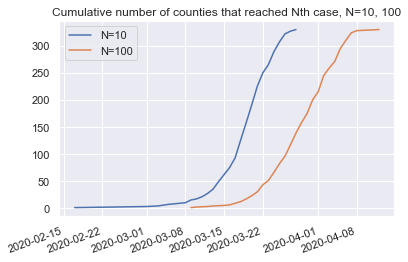

In [11]:
# Calculate date of Nth case for each county
reference_date1 = feature_engineering.date_Nth_case(confirmed_cases_df, N=10)
reference_date2 = feature_engineering.date_Nth_case(confirmed_cases_df, N=100)
reference_date1.value_counts().sort_index().cumsum().plot(rot=20, label='N=10')
reference_date2.value_counts().sort_index().cumsum().plot(rot=20, label='N=100')
plt.title(f'Cumulative number of counties that reached Nth case, N=10, 100')
plt.legend(loc='best')
plt.show()

#### Number of days between 10th and 100th case in  each county

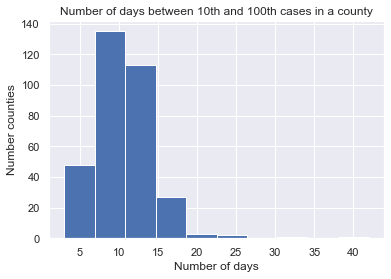

In [12]:
(reference_date2-reference_date1).map(lambda x: x.days).plot.hist(density=False, cumulative=False)
plt.ylabel('Number counties')
plt.xlabel('Number of days')
plt.title('Number of days between 10th and 100th cases in a county')
plt.show()

*****

#### Number of daily new cases over time

For the sake of clarity, we normalized the number of new confirmed cases by the maximum value for the respective country, in order to remove scale variations across different counties.

In other words, the heaptmap shown below was row-normalized to the range [0,1]. 

This plot helps visualize the 3 main stages of the disease that an affected county usually goes through. Yellow streaks along each row indicates the peak phase of the disease in a county, while purple regions indicate beginning or recovery phases of the disease.

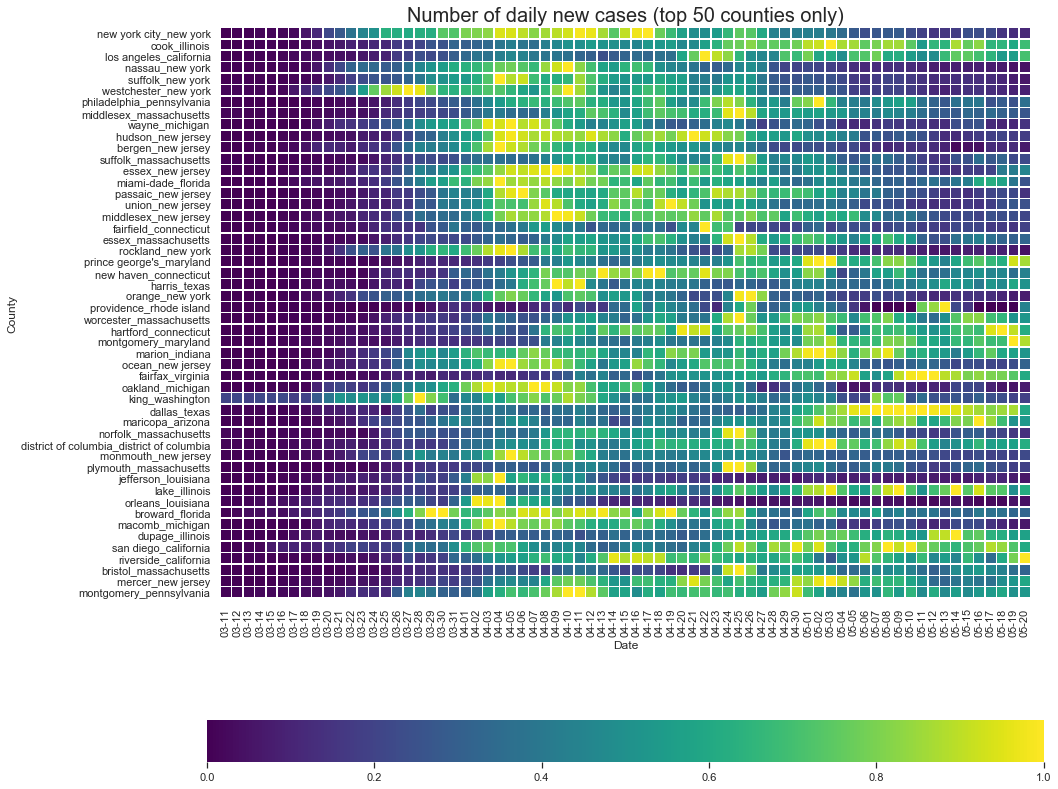

In [13]:
## TO DO: put all this in a function

K = 50  # number of covered counties

confirmed_cases_ts = feature_engineering.get_confirmed_cases_time_series_(confirmed_cases_df)

new_confirmed_cases_ts = feature_engineering.get_new_confirmed_cases_(confirmed_cases_df, smoothing_ws=3)

top_counties = confirmed_cases_ts.max(axis=0).sort_values(ascending=False).head(K).index

# Select locations with the highest number of cases

new_confirmed_cases_ts = new_confirmed_cases_ts[top_counties]

# Normalize each time series to the range [0,1]

new_confirmed_cases_ts = new_confirmed_cases_ts.apply(lambda x: x/max(x))

df_temp = new_confirmed_cases_ts.iloc[50:,:].T
df_temp.columns = df_temp.columns.strftime("%m-%d")
plt.figure(figsize=(15, 15))
sns.heatmap(df_temp, fmt="d", linewidths=.5, square=True,
            linecolor='white', annot=False, cmap="viridis", cbar=True, cbar_kws={"orientation": "horizontal"})
plt.ylabel('County')
plt.xlabel('Date')
plt.title(f'Number of daily new cases (top {K} counties only)', y=1.05, size=20)
plt.show()

*****

### Which NPI's were most/least adopted and when?

#### Distribution of number of adopted NPI's in a county

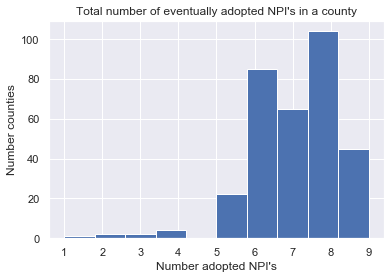

In [18]:
npi_data_df.pivot(index='county_state', columns='npi', values='start_date').notnull().sum(axis=1).plot.hist()
plt.xlabel('Number adopted NPI\'s')
plt.ylabel('Number counties')
plt.title('Total number of eventually adopted NPI\'s in a county')
plt.show()

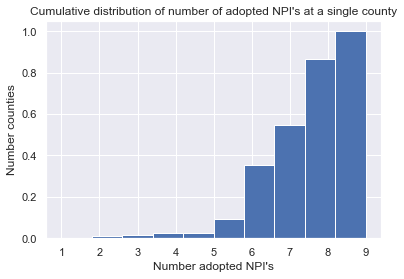

In [19]:
npi_data_df.pivot(index='county_state', columns='npi', values='start_date').notnull().sum(axis=1).plot.hist(density=True, cumulative=True)
plt.xlabel('Number adopted NPI\'s')
plt.ylabel('Number counties')
plt.title('Cumulative distribution of number of adopted NPI\'s at a single county')
plt.show()

#### Percent NPI adoption

What fraction of counties have eventually adopted each NPI.

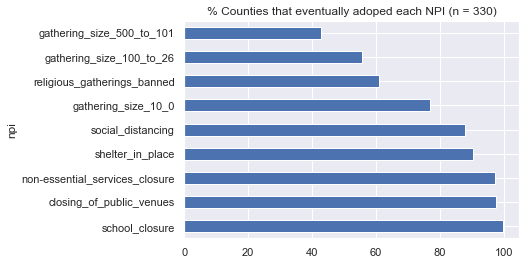

In [20]:
npi_percent_adoption_df = npi_data_df.pivot(index='county_state', columns='npi', values='start_date').notnull().mean()*100

npi_percent_adoption_df.sort_values(ascending=False).plot.barh()
plt.title(f'% Counties that eventually adoped each NPI (n = {npi_data_df.county_state.nunique()})')
plt.show()

#### Percent NPI adoption over time

Here we look into the fraction of counties that have adopted each NPI over time. According to the plot below, clearly not all NPI's were adopted at the same time. School closures tended to be the earliest, followed by closing of public venues and social distancing.

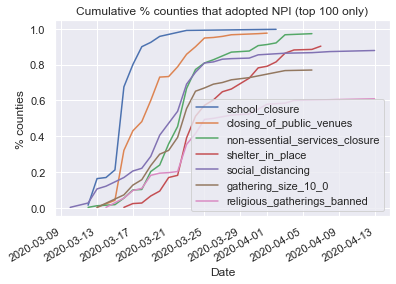

In [21]:
K = 7  # number of selected top NPI's

top_adopted_npis = npi_percent_adoption_df.sort_values(ascending=False).head(K).index

for x in top_adopted_npis:
    idx = npi_data_df.npi == x
    npi_data_df.loc[idx, 'start_date'].value_counts(normalize=False).map(lambda x: x/npi_data_df.county_state.nunique()).sort_index().cumsum().plot(rot=30, label=x)
    plt.ylabel('% counties')
    plt.xlabel('Date')
    plt.title(f'Cumulative % counties that adopted NPI (top {N} only)')
plt.legend(loc='best')
plt.show()

#### Number of adopted NPI's over time in each county

While the plot in the previous section is aggregated over all counties, the plot below zooms in on different counties, for the 50 most affected counties. For each county, we plot the total number of adopted NPI's so far across time. The counties are shown in decreasing order of total number of confirmed cases. A longer yellow streak along a row indicates earlier adoption of all NPI's in that county.

While there is wide variation among the counties, there is no discernible pattern as far as the effect of earlier adoption on number of confirmed cases.  This may be explained by the fact that different counties are affected at different times.

In [22]:
cum_num_npis_matrix = npi_data_df.pivot_table(index='county_state', columns='start_date', values='npi', aggfunc='count').fillna(value=0).cumsum(axis=1)
cum_num_npis_matrix.columns.name = 'start_date'
cum_num_npis_matrix.shape

(330, 30)

In [23]:
npi_data_df.start_date.min(), npi_data_df.start_date.max()

(Timestamp('2020-03-10 00:00:00'), Timestamp('2020-04-13 00:00:00'))

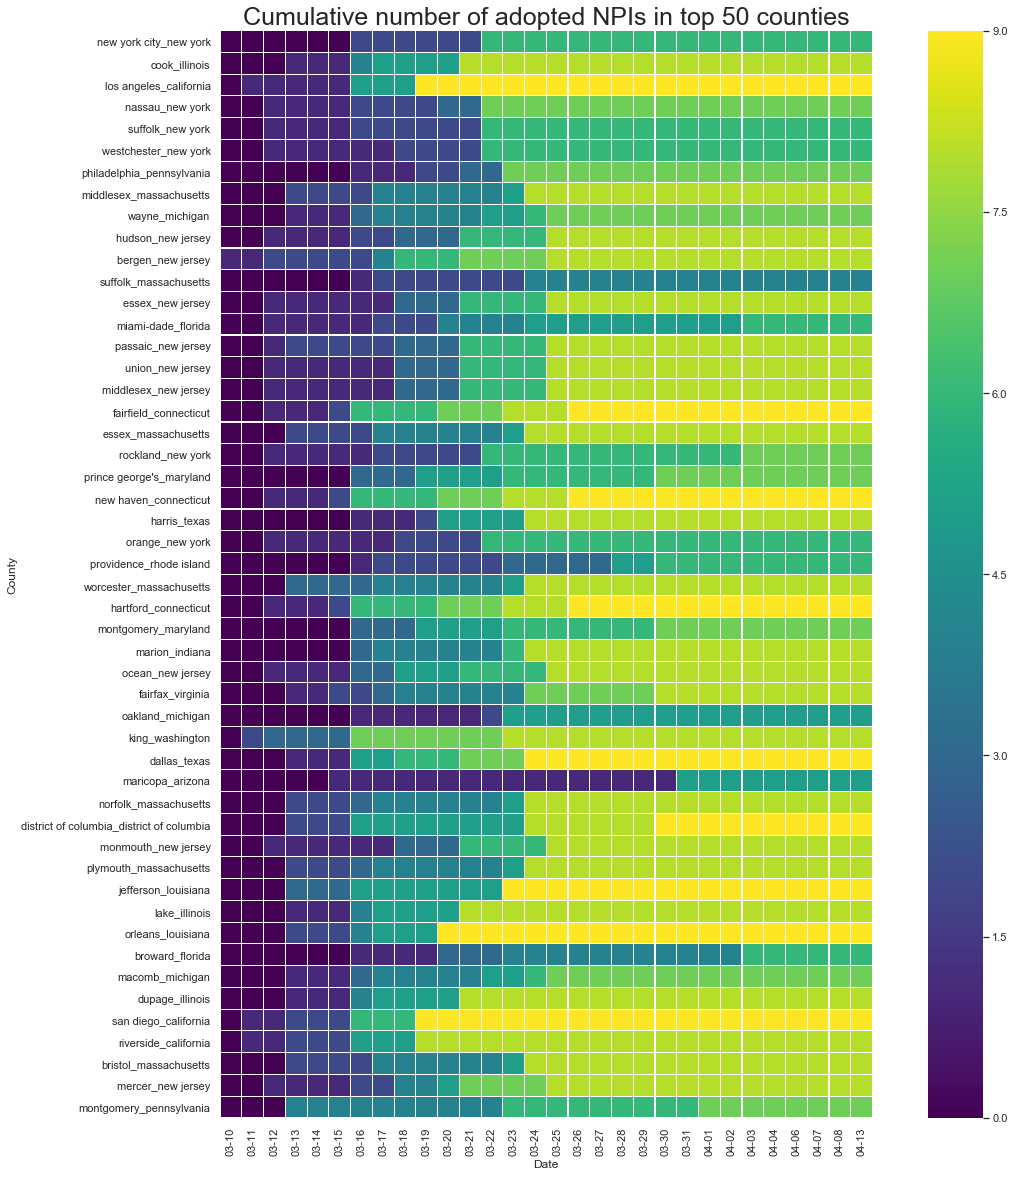

In [24]:
K = 50  # number of selected counties for display

confirmed_cases_ts = feature_engineering.get_confirmed_cases_time_series_(confirmed_cases_df)
top_counties = confirmed_cases_ts.max(axis=0).sort_values(ascending=False).head(K).index

df_temp = cum_num_npis_matrix.loc[top_counties]
df_temp.columns = df_temp.columns.strftime("%m-%d")
plt.figure(figsize=(20, 20))
sns.heatmap(df_temp, fmt="d", linewidths=.1, square=True,
            linecolor='white', annot=False, cmap="viridis", cbar=True)  # , cbar_kws={"orientation": "horizontal"}
plt.ylabel('County')
plt.xlabel('Date')
plt.title(f'Cumulative number of adopted NPIs in top {K} counties', y=1.05, size=25)
plt.show()

### When were NPI's adopted relative to onset of disease in a county?

In this section, we aim to assess how quickly counties have reacted/responded to the onset of the disease. This is important because variation in the speed of implementing NPI's will likely lead to variation in the degree of their effectiveness and impact on infection rate.

The heatmap below attempts to capture this relationship. The $x,y$th value of this heatmap contains the number of adopted NPI's within $x$ days of the $N$th confirmed case in the $y$th county, where $N$ is a small fixed value.

**Key takeaways**

This heatmap suggests that there is a wide variation in how quickly counties have reacted/responded to the onset of the disease. The earliest adopters have acted about 12 days before the 10th case (San Bernadino, California); the latest adopters have acted 25 days after the 10th case (Douglas, Nebraska).  Furthermore, this variation is more pronounced with $N$=100 than with $N$=10.

In [25]:
#sns.set(font_scale=1.0)

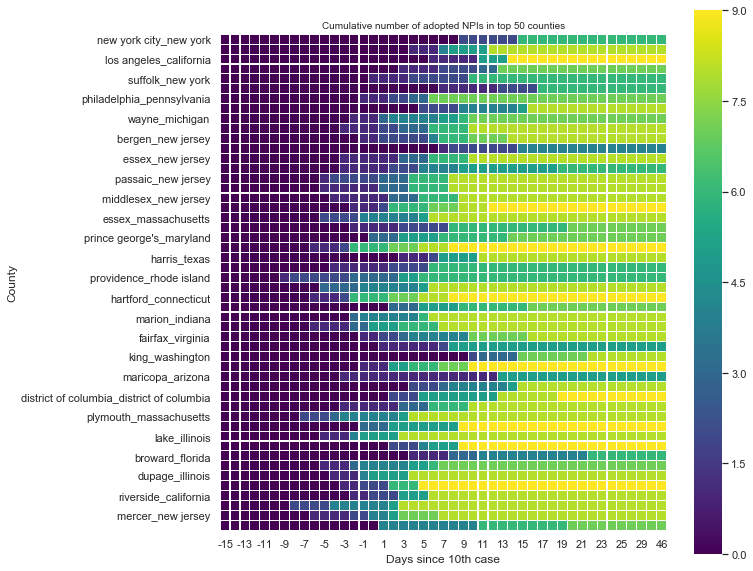

In [26]:
visualization.foo1(npi_data_df.copy(), confirmed_cases_df, N=10, K=50)

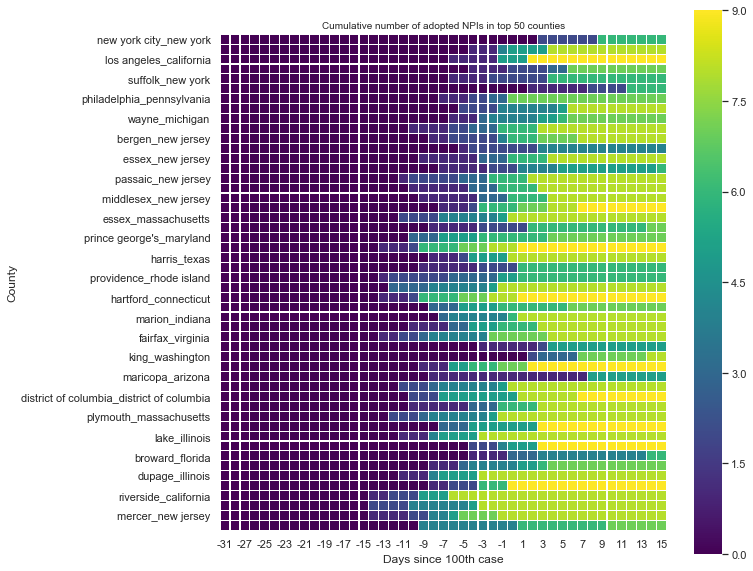

In [27]:
visualization.foo1(npi_data_df.copy(), confirmed_cases_df, N=100, K=50)

****

### Is there a relationship between disease progression and early NPI adoptions in a county?

To simplify analysis, we aggregate early NPI adoptions by a single variable: the number of NPI's adopted before the $N$th confirmed case, for some small value of $N$.

The progression of the disease can be measured in at least 3 different ways:

- by the total number of confirmed cases, denoted $C(t)$.
- by the number of daily *new* cases, calculated as $C(t) - C(t-1)$, since the number of cases is observed daily.
- by the infection rate,  calculated as $\frac{C(t) - C(t-p)}{C(t-1)}$, where $p$ is a small integer, usually larger than 1 to reduce noise.

In the 3 subsections below, we look into the relationship between number of early NPI adoptions and each of the above three variables that characterize disease progression.

#### Total number of cases vs. number of adopted NPI's prior to Nth case

Here we will explore the relationship between the following two variables for each county:

1. total number of confirmed cases (recorded by the final date in the dataset); and 
2. number of adopted NPI's by the $N$th confirmed case for some small value of $N$.

The 2 plots below correspond to $N$= 10 and 100 respectively. 

**Key takeaways**:

- Both plots suggest the total number of confirmed cases generally decreases with the number of adopted measures.

- The relationship seems a bit stronger with $N=100$ than $N=10$.

- The impact of number of adoptions on number of cases is not linear: there seems to be three intervals that are significantly different from each other, with little difference within each interval: 0 adoptions, 1-2 adoptions, and 3-9 adoptions.

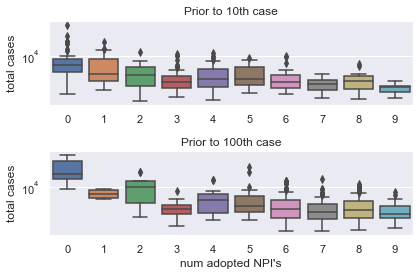

In [28]:
plt.subplot(2,1,1)
visualization.foo2(npi_data_df.copy(), confirmed_cases_df, N=10)
plt.subplot(2,1,2)
visualization.foo2(npi_data_df.copy(), confirmed_cases_df, N=100)
plt.xlabel('num adopted NPI\'s')
plt.tight_layout()
plt.show()

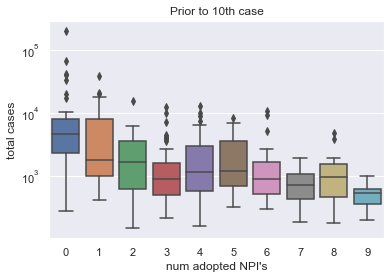

In [29]:
visualization.foo2(npi_data_df.copy(), confirmed_cases_df, N=10)
plt.xlabel('num adopted NPI\'s')
plt.show()

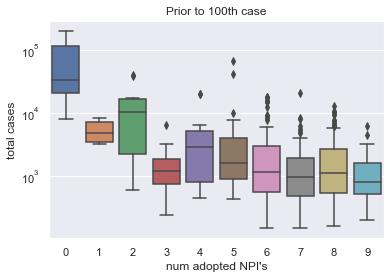

In [30]:
visualization.foo2(npi_data_df.copy(), confirmed_cases_df, N=100)
plt.xlabel('num adopted NPI\'s')
plt.show()

*****

#### Peak number of NEW cases vs. number of adopted NPI's prior to Nth case

Here we explore the relationship between the following two variables for each county:

1. the peak number of daily new cases; and 
2. number of adopted NPI's in the early phases of the disease.

Interestingly, the plots obtained below are almost identical to those in the previous subsection, except for the difference in y-scale. Intuitively, this may be due to the exponential nature of the underlying phenomenon.

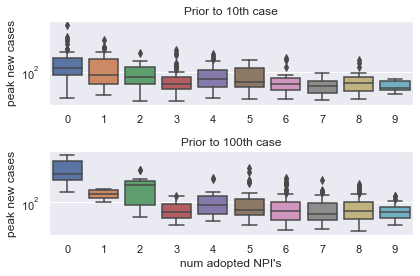

In [31]:
plt.subplot(2,1,1)
visualization.foo3(npi_data_df.copy(), confirmed_cases_df, N=10)
plt.subplot(2,1,2)
visualization.foo3(npi_data_df.copy(), confirmed_cases_df, N=100)
plt.xlabel('num adopted NPI\'s')
plt.tight_layout()
plt.show()

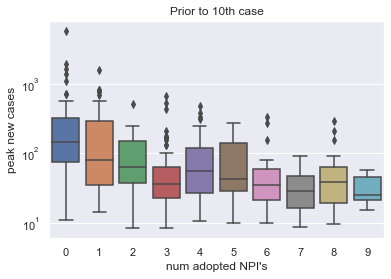

In [32]:
visualization.foo3(npi_data_df.copy(), confirmed_cases_df, N=10)
plt.xlabel('num adopted NPI\'s')
plt.show()

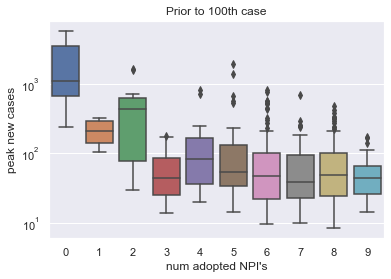

In [33]:
visualization.foo3(npi_data_df.copy(), confirmed_cases_df, N=100)
plt.xlabel('num adopted NPI\'s')
plt.show()

*****

#### Infection rate vs. number of adopted NPI's

Here we look into the relationship between early adoption of NPI's and infection rate based on bivariate plots of the following two variables:

1. number of adopted NPI's at the onset of the disease, say prior to the Nth case, for some small value of $N$; and 

2. infection rate a few weeks after the onset of the disease, say $D$ days after the $N$th case. We use the parameter $D$ to account for the lag between when NPI's are adopted and when their effect is observed on infection rate.

Below we have plotted infection rate and number of adopted NPI's for different values of the $N$ and $D$.

These plots follow a similar trend as the plots in the previous 2 subsections. Also, the relationship seems more significant with the values of N=100 and D=21.

In [34]:
#sns.set(font_scale=0.5)

**Plot Title**: Infection rate 21 days after Nth case vs. num adopted NPI prior to Nth case, with N=10, 100

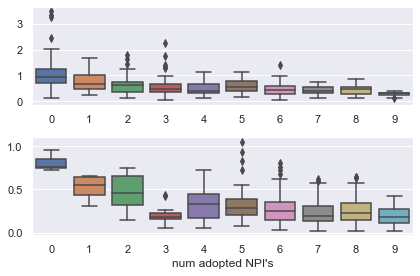

In [95]:
plt.subplot(2,1,1)
visualization.foo4(npi_data_df.copy(), confirmed_cases_df, N=10, D=21)
plt.subplot(2,1,2)
visualization.foo4(npi_data_df.copy(), confirmed_cases_df, N=100, D=21)
plt.xlabel(f'num adopted NPI\'s')
plt.tight_layout()
plt.show()

**Plot Title**: Infection rate 14 days after Nth case vs. num adopted NPI prior to Nth case, with N=10, 100.

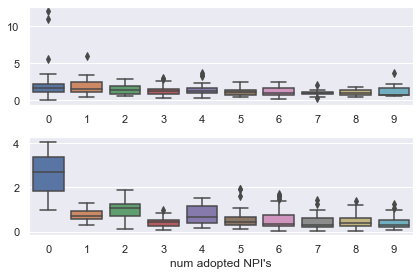

In [96]:
plt.subplot(2,1,1)
visualization.foo4(npi_data_df.copy(), confirmed_cases_df, N=10, D=14)
plt.subplot(2,1,2)
visualization.foo4(npi_data_df.copy(), confirmed_cases_df, N=100, D=14)
plt.xlabel(f'num adopted NPI\'s')
plt.tight_layout()
plt.show()

### Timeline of NPI adoption vs. progression of disease for specific counties

## Feature extraction & engineering

for subsequent supervised and unsupervised learning.

In [47]:
aligned_npi_matrix, aligned_infection_rate_ts = feature_engineering.feature_engineering (
    npi_data_df, confirmed_cases_df, N=100, D=14, num_periods=5, smoothing_ws=3)

In [49]:
list(map(lambda x: x.shape, [aligned_npi_matrix, aligned_infection_rate_ts]))

[(330, 9), (330, 73)]

## Descriptive Analysis: Unsupervised learning

## Predictive Analysis: classification model

### Random forest model

In [ ]:
# Hyperparameters

N = 100
D1 = 7
D2 = 14

In [50]:
aligned_npi_matrix, aligned_infection_rate_ts = feature_engineering.feature_engineering (
    npi_data_df, confirmed_cases_df, N=N, D=D1, num_periods=5, smoothing_ws=3)

In [51]:
target_vec = aligned_infection_rate_ts.iloc[:, D2]
target_vec.shape

(330,)

In [52]:
target_vec.quantile(q=0.66)

0.31384557680861064

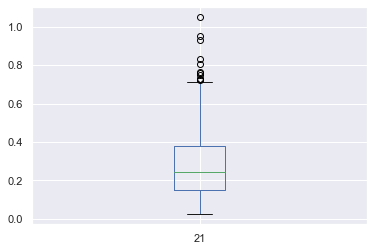

In [55]:
target_vec.plot.box()
plt.show()

Best hyperparameter values: 
{'max_depth': 2, 'max_features': 2, 'n_estimators': 50}

Performance of best classification model:

Cross-validation performance:
CV mean F1: 0.5361179280489625
CV mean ROC AUC: 0.7608730158730158
CV mean Accuracy: 0.7689404934687953

Test performance:
Accuracy: 0.803030303030303
AUC: 0.7499999999999999
Precision/Recall (classification report):
              precision    recall  f1-score   support

        high       0.76      0.59      0.67        22
         low       0.82      0.91      0.86        44

    accuracy                           0.80        66
   macro avg       0.79      0.75      0.76        66
weighted avg       0.80      0.80      0.80        66

Confusion matrix:
col_0  high  low
21              
low       4   40
high     13    9

Analyzing classification errors:
	Number of errors 13

                       y_true  high_pred_prob
county_state                                 
atlantic_new jersey      high        0.154919
san joaquin_calif

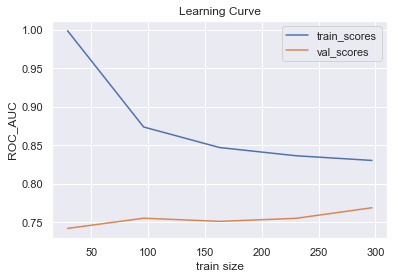

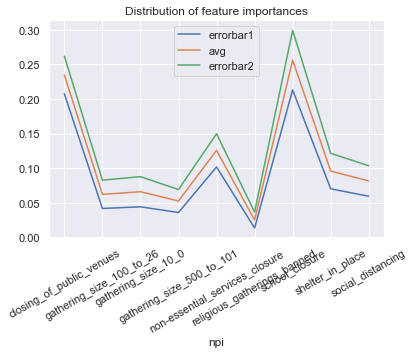

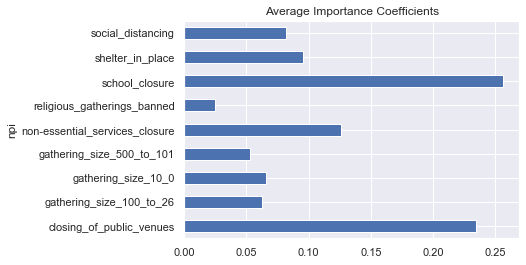

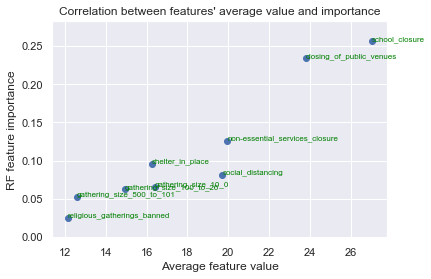

In [54]:
prediction.build_classification_model(aligned_npi_matrix, target_vec, 0.66)

****

## Predictive Analysis: regression model

## Prescriptive Analysis

Will build an interactive plot that allows the user to select NPI settings in order to determine predicted infection rate.